<a href="https://colab.research.google.com/github/acastellanos-ie/NLP-MBDS-EN/blob/main/05_language_modeling/language_modeling_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Modeling (Decoder-Only Architecture)

**Learning Objective:**
Dismantle the illusion of "Generative AI". A Large Language Model does not "think" or "write" paragraphs. Its only physical capability is calculating the statistical probability distribution of the *very next token*.

In this lab, we will open the black box. We will bypass the high-level `generate()` APIs and manually build an Auto-regressive Generation loop from scratch using raw mathematical logits.

In [22]:
# 1. Environment Setup
!pip install -q transformers torch matplotlib numpy

### Phase 1: The Engine (Loading a Decoder)
We will use GPT-2. While older, its core architecture is identical to GPT-4 or Llama-3: it is a Transformer Decoder trained strictly on Next-Token Prediction.

In [23]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
import numpy as np

# Load Model and Tokenizer
model_id = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_id)
model = GPT2LMHeadModel.from_pretrained(model_id)

# Set to evaluation mode (turns off dropout layers for deterministic outputs)
model.eval()
print(f"{model_id} loaded successfully. Vocabulary Size: {tokenizer.vocab_size}")

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


gpt2 loaded successfully. Vocabulary Size: 50257


### Phase 2: First Principles - The Probability Distribution
Let's feed the model an unfinished sentence. We don't want it to generate text yet. We want to see the raw scores (Logits) it assigns to all 50,257 words in its vocabulary for the next position.

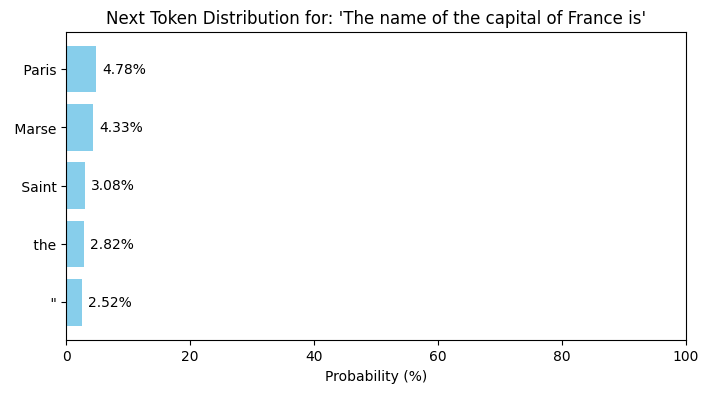

In [24]:
prompt = "The name of the capital of France is"
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Forward pass without calculating gradients (saves memory)
with torch.no_grad():
    outputs = model(input_ids)

# The model returns logits for EVERY token in the sequence.
# We only care about the predictions for the VERY LAST token.
next_token_logits = outputs.logits[0, -1, :]

# Convert raw logits into probabilities (0 to 1) using Softmax
probabilities = torch.nn.functional.softmax(next_token_logits, dim=-1)

# Find the top 5 most likely next tokens
top_k = 5
top_probs, top_indices = torch.topk(probabilities, top_k)

# Decode indices back to human-readable text
top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

# --- Visualization ---
plt.figure(figsize=(8, 4))
plt.barh(top_tokens[::-1], top_probs.numpy()[::-1] * 100, color='skyblue')
plt.xlabel("Probability (%)")
plt.title(f"Next Token Distribution for: '{prompt}'")
plt.xlim(0, 100)
for i, v in enumerate(top_probs.numpy()[::-1] * 100):
    plt.text(v + 1, i, f"{v:.2f}%", va='center')
plt.show()


# TAKEAWAY:

Notice that `Paris` has a high probability.

The model "knows" the answer not because it has a database, but because in its training data, `Paris` statistically followed those exact previous words highly often.

### Phase 3: Building Auto-Regressive Generation from Scratch
Now we will build the engine.
1. Predict the next token.
2. Take the most probable token (Greedy Decoding) and append it to our prompt.
3. Feed the new, longer prompt back into the model.
4. Repeat.

In [28]:
def generate_from_scratch(prompt, max_new_tokens=15, penalty=1.2):
    current_input_ids = tokenizer.encode(prompt, return_tensors="pt")

    print(f"\nStarting Prompt: '{prompt}'")
    print("-" * 40)

    for step in range(max_new_tokens):
        with torch.no_grad():
            outputs = model(current_input_ids)

        next_token_logits = outputs.logits[0, -1, :]

        # SIMPLE REPETITION PENALTY:
        # Reduce the score of tokens that have already appeared in the sequence
        for token_id in current_input_ids[0]:
            if next_token_logits[token_id] > 0:
                next_token_logits[token_id] /= penalty
            else:
                next_token_logits[token_id] *= penalty

        next_token_id = torch.argmax(next_token_logits)
        next_word = tokenizer.decode([next_token_id])
        print(f"Step {step+1}: '{next_word}'")

        current_input_ids = torch.cat([current_input_ids, next_token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

    final_text = tokenizer.decode(current_input_ids[0])
    print("-" * 40)
    print(f"Final Output:\n{final_text}")

# Testing with penalty to avoid the loop
generate_from_scratch("The name of the capital of France is")


Starting Prompt: 'The name of the capital of France is'
----------------------------------------
Step 1: ' Paris'
Step 2: '.'
Step 3: ' The'
Step 4: ' city'
Step 5: ' was'
Step 6: ' founded'
Step 7: ' in'
Step 8: ' 17'
Step 9: '89'
Step 10: ' by'
Step 11: ' Charles'
Step 12: ' I'
Step 13: ','
Step 14: ' who'
Step 15: ' had'
----------------------------------------
Final Output:
The name of the capital of France is Paris. The city was founded in 1789 by Charles I, who had


### Phase 4: The Problem with Greedy Decoding
If we ALWAYS pick the most mathematically probable token (Argmax), the model becomes boring and often gets stuck in repetitive loops.

This is why the **Temperature** parameter was invented. Instead of picking the absolute top token, we "sample" from the probability distribution. Higher temperature flattens the distribution, allowing "weaker" words to sometimes be chosen, increasing creativity (or hallucination).

In [29]:
# Using the built-in generate API with extreme temperature differences
prompt = "The name of the capital of France is"
inputs = tokenizer(prompt, return_tensors="pt")

# Low Temperature (Very predictable, high repetition risk)
out_low = model.generate(
    **inputs,
    max_new_tokens=20,
    do_sample=True,
    temperature=0.1,
    repetition_penalty=1.1,
    pad_token_id=tokenizer.eos_token_id
)

# High Temperature (Chaotic, high 'creativity')
out_high = model.generate(
    **inputs,
    max_new_tokens=20,
    do_sample=True,
    temperature=1.5,
    pad_token_id=tokenizer.eos_token_id
)

print("--- LOW TEMPERATURE (0.1) + PENALTY ---")
print(tokenizer.decode(out_low[0], skip_special_tokens=True))

print("\n--- HIGH TEMPERATURE (1.5) ---")
print(tokenizer.decode(out_high[0], skip_special_tokens=True))

--- LOW TEMPERATURE (0.1) + PENALTY ---
The name of the capital of France is Paris. The French word for "city" means a city in which there are many cities, and

--- HIGH TEMPERATURE (1.5) ---
The name of the capital of France is Marseille "Messelinhalle." By a later order, in July this year,
